# Introduction

Le but de ce notebook est de presenter le code utilise pour simuler l'etat d'Hadamard pour un qubit: dans un etat pur et dans un etat mixte contenant du bruit en utilisant la blibliotheque de simulation quantique [QuTiP](https://qutip.org/). Ce notebook presente ensuite le code utilise pour effectuer une tomographie quantique sur cet etat afin de reconstituer sa matrice densite. On utilisera les methodes d'inversion lineaire et maximum de vraisemblance.

## L'etat d'Hadamard

L'etat d'Hadamard est l'etat resultant de l'application de la porte d'Hadamard **H** qui transforme un qubit dans l'etat $|0\rangle$ vers un etat superpose $(|0\rangle+|1\rangle)/\sqrt 2$. 

Sur la sphere de Bloch, pour un etat pur, l'etat d'Hadamard est correspond a l'axe **X** comme on peut le voir ci dessous. Il represente une superposition equiprobable des etats $|0\rangle$ et $|1\rangle$.

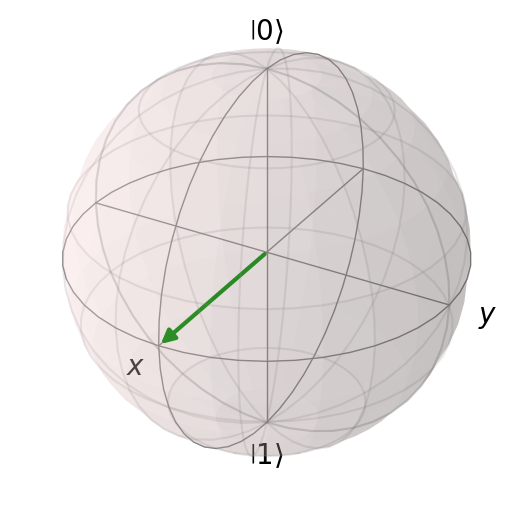

In [23]:
from qutip import basis, Bloch
import numpy as np
np.set_printoptions(precision=3)

state_0 = basis(2, 0)
state_1 = basis(2, 1)
b = Bloch()
b.add_states((state_0 + state_1)/np.sqrt(2))
b.show()

# Simulation

Dans QuTip, nous allons utiliser la fonctionnalite qui permet de simuler l'execution de circuit quantiques afin de simuler l'etat et d'effectuer des mesures dans differentes bases. Dans QuTip, la porte d'Hadamard est notee **SNOT**. Voici, ci dessous le code necessaire pour creer un etat d'Hadamard en utilisant un circuit dans QuTiP.

In [24]:
%%capture
# Installation des pre-requis
!pip install qutip==4.7.5

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [25]:
from qutip.qip.circuit import QubitCircuit

qc = QubitCircuit(N=1, num_cbits=1) # On cree un circuit avec 1 qubit et 1 bit classique
qc.add_gate("SNOT", targets=[0]) # On applique la porte d'Hadamard sur le qubit 0
qc.add_measurement("M0", targets=[0], classical_store=0) # On ajoute une mesure du qubit 0 stocke dans le bit classique 0

# TODO Generer l'image du circuit

**Note:** Pour le moment nous nous contenterons de simuler un etat pur/ideal. Dans la prochaine iteration du code, nous allons ajouter du bruit (dont la nature est a definir) pour rendre l'etat mixte.

La tomographie quantique consiste a effecter une serie de mesures dans une base complete afin de reconstituer la matrice densite de l'etat. Dans le cas d'un qubit a deux niveaux, on utilisera les bases de Pauli **X**, **Y** et **Z**:
- Pour la base **X**, il suffit d'appliquer la porte d'Hadamard **H** (ou **SNOT** dans QuTiP) pour projeter dans cette base. Qui dans notre cas donnera toujours $|0\rangle$ car appliquer la porte d'Hadamard deux fois revient a l'identite.
- Pour la base **Y**, c'est un peu plus complexe: il faut appliquer la sequence suivante de portes **S**, **SNOT** et **T**. 
- Pour la base **Z**, il n'y a rien a faire car les mesures s'effectuent par defaut dans cette base.

La matrice densite theorique pour un etat d'Hadamard pur est : $ \left( \begin{matrix} 0.5 & 0.5 \\ 0.5 & 0.5 \end{matrix} \right) $

Voici le code utilise pour generer les circuits qui vont preparer l'etat d'Hadamard et effectuer les mesures dans chacunes de ces bases. Pour chacun des circuits, on obtiendra soit:
- $|0\rangle$ $\left(\begin{smallmatrix} 1 \\ 0 \end{smallmatrix} \right)$
- $|1\rangle$ $\left(\begin{smallmatrix} 0 \\ 1 \end{smallmatrix} \right)$

In [26]:
from qutip import basis, Qobj
from qutip.qip.circuit import QubitCircuit
import numpy as np

def prepare_hadamard_state_circuit():
    qc = QubitCircuit(N=1, num_cbits=1)
    qc.add_gate("SNOT", targets=[0])
    return qc

def simulate_measurement_X(initial_state):
    qc = prepare_hadamard_state_circuit()
    # Mesure dans dans la base X
    qc.add_gate("SNOT", targets=[0])
    qc.add_measurement("M0", targets=[0], classical_store=0)
    return qc.run(state=initial_state)


def simulate_measurement_Y(initial_state):
    qc = prepare_hadamard_state_circuit()
    # Mesure dans la base Y
    sdagger = Qobj(np.array([[1., 0],[0., -1.j]]))
    qc.user_gates = {"SDAG": sdagger}
    qc.add_gate("SDAG", targets=[0])
    qc.add_gate("SNOT", targets=[0])
    qc.add_measurement("M0", targets=[0], classical_store=0)
    measurement = qc.run(state=initial_state)
    if measurement.full()[0] == (0 + 0j):
        return Qobj(np.array([1, 0]))
    else:
        return Qobj(np.array([0, 1]))

def simulate_measurement_Z(initial_state):
    qc = prepare_hadamard_state_circuit()
    # Mesure dans la base Z (base par defaut)
    qc.add_measurement("M0", targets=[0], classical_store=0)
    return qc.run(state=initial_state)

Il suffit ensuite d'executer ces circuits un nombre donne de fois et de collecter les resultats qui seront utilises pour appliquer les methodes de tomographie.

In [27]:
shots_number = 2000

# On prepare l'etat |0>
initial_state = basis(2, 0)

results_x_ideal = Qobj(np.array([0, 0]))
results_y_ideal = Qobj(np.array([0, 0]))
results_z_ideal = Qobj(np.array([0, 0]))

for _ in range(0, shots_number):    
    results_x_ideal +=  simulate_measurement_X(initial_state=initial_state)    
    results_y_ideal +=  simulate_measurement_Y(initial_state=initial_state)    
    results_z_ideal +=  simulate_measurement_Z(initial_state=initial_state)    

# TODO Ajouter un diagramme a la Qiskit
print("X: {} \nY: {} \nZ: {}".format(results_x_ideal.full(), results_y_ideal.full(), results_z_ideal.full()));

X: [[2000.+0.j]
 [   0.+0.j]] 
Y: [[ 981.+0.j]
 [1019.+0.j]] 
Z: [[ 998.+0.j]
 [1002.+0.j]]


# Methode d'inversion lineaire

Toute matrice densite d'un systeme a deux niveaux peut etre ecrite sous la forme: $\rho = 0.5*(I + p_x*\sigma_x + p_y*\sigma_y +p_z*\sigma_z) $ ou $\sigma$ representent les matrices de Pauli et $p$ representent les valeurs moyennes de ces observables. Dans notre cas, on suppose que la simulation donne une bonne estimation de la valeur moyenne. 

Pour calculer la valeur moyenne, on associe pour chacune des matrices de Pauli, la valeur propre +1 a l'etat $|0\rangle$ et la valeur propre -1 a l'etat $|1\rangle$.

In [28]:
from qutip import qeye, sigmax, sigmay, sigmaz

# Calcul des valeurs moyennes
p_x = ((results_x_ideal.full()[0] - results_x_ideal.full()[1]) / shots_number)[0]
p_y = ((results_y_ideal.full()[0] - results_y_ideal.full()[1]) / shots_number)[0]
p_z = ((results_z_ideal.full()[0] - results_z_ideal.full()[1]) / shots_number)[0]

# Reconstruction de la matrice densite
reconstructed_density_matrix = 0.5*(qeye(2) + p_x*sigmax() + p_y*sigmay() + p_z*sigmaz())
print("Matrice densite reconstruite:\n{} ".format(reconstructed_density_matrix.full()))

# Matrice densite theorique pour l'etat d'Hadamard
ideal_hadamard_state = (basis(2, 0) +  basis(2, 1)) / np.sqrt(2)
ideal_hadamard_density_matrix = ideal_hadamard_state.proj()
print("Matrice densite theorique:\n{}".format(ideal_hadamard_density_matrix.full()))

Matrice densite reconstruite:
[[0.499+0.j    0.5  +0.009j]
 [0.5  -0.009j 0.501+0.j   ]] 
Matrice densite theorique:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


# Methode du maximum de vraisemblance

Le probleme de la methode d'inversion lineaire est qu'elle peut donner des resultats qui sont physiquement impossibles (par exemple avec des traces superieures a 1). La methode du maximum de vraisemblance permet d'obtenir des resultats physiquement possible. 

Pour cela, on va essayer de maximiser une fonction de vraisemblance qui donne la probabilite d'obtenir les resultats moyens de la simulation avec une matrice densite $\rho$ donnee, sous un ensemble de contraintes: 

En pratique, il est souvent beaucoup plus simple de minimiser une fonction. La fonction que l'on cherche a minimiser dans note cas est : $\sum(p_i - Tr(\rho*\sigma_i))^2$ ou $p_i$ represente la valeur moyenne obtenue lors de la simulation, $\rho$ la matrice densite qu'on essaie d'optimiser et $\sigma_i$ les matrices de Pauli. $Tr(\rho*\sigma_i)$ represente la valeur moyenne de l'observable $\sigma_i$ avec la matrice densite $\rho$

Il faut ensuite contraindre la matrice densite pour obtenir des resultats physiquement corrects. Dans le cas general, une matrice 2x2 complexe necessite 8 coefficients. Dans le cas d'une matrice densite d'un etat pur, 4 coefficients uniquement sont necessaires:  $ \left( \begin{matrix} \alpha & \beta + \delta*i \\ \beta - \delta*i & 1 -\alpha \end{matrix} \right)$ avec $0 <=\alpha<= 1$.

En effet, la matrice doit etre hermitienne, donc les elements non diagonaux doivent etre conjugues, et il s'agit d'une matrice densite et la trace des elements diagonaux doit etre egale a 1. 

In [29]:
observables = [sigmax(), sigmay(), sigmaz()]
expected_values_ideal = [p_x, p_y, p_z]

def likelihood_function(params):
    likelihood_inverse = 0

    density_matrix_array = np.array(
    [ [params[0], params[1] + 1j*params[2]],
      [ params[1] - 1j*params[2], 1-params[0]]
    ])
    density_matrix = Qobj(density_matrix_array)
    
    for i in range(0, len(observables)):
        likelihood_inverse += (expected_values_ideal[i] - (density_matrix*observables[i]).tr())**2
    return likelihood_inverse

On utilise le module `minimize` de la bibliotheque scientifique `scipy`. Dans notre cas, une optimisation classique devrait etre suffisante. D'autres algorithmes d'optimisation sont disponibles pour ce module. En general dans les problemes d'optimisation, il faut s'assurer de ne pas tomber dans une minimum local. 

In [30]:
from scipy.optimize import minimize

# On part d'une matrice densite quelconque qu'on va chercher a optimiser
initial_guess_params = [np.random.uniform(), np.random.uniform(), np.random.uniform(), np.random.uniform()]  
# On contraint le premier element diagonal a etre entre 0 et 1. 
bounds = [(0, 1), (None, None), (None, None), (None, None)] 

# On effectue la minimisation de la fonction "inverse" de vraisemblance 
results = minimize(likelihood_function, initial_guess_params, bounds=bounds)

/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py:360: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


In [31]:
# On reconstruit la matrice densite par maximum de vraisemblance (
reconstructed_density_matrix_max = np.array(
    [ [results.x[0], results.x[1] + 1j*results.x[2]],
      [ results.x[1] - 1j*results.x[2], 1-results.x[0]]
    ])
print("Matrice densite reconstruite:\n{} ".format(reconstructed_density_matrix_max))
print("Matrice densite theorique:\n{}".format(ideal_hadamard_density_matrix.full()))

Matrice densite reconstruite:
[[0.499+0.j    0.5  +0.009j]
 [0.5  -0.009j 0.501+0.j   ]] 
Matrice densite theorique:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


Maintenant, nous allons ajouter du bruit au circuit afin de simuler un etat mixte. Nous allons ajouter un bruit de type **decoherence** qui represente le fait que le qubit perde de l'energie en faveur de son environment exterieur. Il s'agit d'un type de bruit relativement courant pour les qubit de type supraconducteurs qui doivent etre maintenus a des tempratures de l'odre du mK.

Dans QuTiP, la simulation de bruit s'effectue grace a la classe `Processor` qui represente le modele de circuit que l'on veut utiliser. Le type de base `LinearSpinChain` nous suffit dans notre cas, car nous n'avons qu'un seul qubit. Pour simuler, un bruit de type decoherence, il suffit d'attribuer des valeurs aux parametres T1 (periode de dephasage) et T2 (periode de relaxation)



In [39]:

from qutip.qip.device import LinearSpinChain

# Create a processor from the circuit
processor_without_noise = LinearSpinChain(N=1)

qc = QubitCircuit(N=1, num_cbits=1)
qc.add_gate("SNOT", targets=[0])
processor_without_noise.load_circuit(qc)

# Les periodes de dephasage sont longues et n'influencent que peu le circuit
processor_without_noise.t1 = 10000.0
processor_without_noise.t2 = 5000.0

initial_state = basis(2, 0)
result = processor_without_noise.run_state(basis(2, 0))
had_pure = result.states[-1]
normalized_density_matrix_pure = had_pure * had_pure.dag()
normalized_density_matrix_pure = (normalized_density_matrix_pure / normalized_density_matrix_pure.tr()).full()
print("Density matrix without noise :\n{} ".format(normalized_density_matrix_pure))

# Create a processor from the circuit
processor_with_noise = LinearSpinChain(N=1)
processor_with_noise.load_circuit(qc)

# Les periodes de dephasage sont courtes et influencent profondement le circuit
processor_with_noise.t1 = 10.0
processor_with_noise.t2 = 5.0
result = processor_with_noise.run_state(basis(2, 0))
had_mixed = result.states[-1]
unnormalized_density_matrix_mixed = had_mixed * had_mixed.dag()
normalized_density_matrix_mixed = (unnormalized_density_matrix_mixed / unnormalized_density_matrix_mixed.tr()).full()
print("Density matrix with noise (Normalised):\n{} ".format(normalized_density_matrix_mixed))
print("Density matrix with noise (Unormalised):\n{} ".format(unnormalized_density_matrix_mixed.full()))

Density matrix without noise :
[[0.5+0.000e+00j 0.5+1.138e-05j]
 [0.5-1.138e-05j 0.5+0.000e+00j]] 
Density matrix with noise (Normalised):
[[0.471+0.j    0.481+0.037j]
 [0.481-0.037j 0.529+0.j   ]] 
Density matrix with noise (Unormalised):
[[0.375+0.j   0.383+0.03j]
 [0.383-0.03j 0.421+0.j  ]] 


In [42]:
from qutip import expect

# Reconstruction etat pur
p_x = expect(sigmax(), had_pure)
p_y = expect(sigmay(), had_pure)
p_z = expect(sigmaz(), had_pure)

reconstructed_density_matrix = 0.5*(qeye(2) + p_x*sigmax() + p_y*sigmay() + p_z*sigmaz())
print("Matrice densite (etat pur) reconstruite (inversion lineaire):\n{} ".format(reconstructed_density_matrix.full()))


# Reconstruction etat mixte
p_x = expect(sigmax(), had_mixed)
p_y = expect(sigmay(), had_mixed)
p_z = expect(sigmaz(), had_mixed)

reconstructed_density_matrix = 0.5*(qeye(2) + p_x*sigmax() + p_y*sigmay() + p_z*sigmaz())
print("Matrice densite (etat mixte) reconstruite (inversion lineaire):\n{} ".format(reconstructed_density_matrix.full()))

Matrice densite (etat pur) reconstruite (inversion lineaire):
[[0.5+0.000e+00j 0.5+1.138e-05j]
 [0.5-1.138e-05j 0.5+0.000e+00j]] 
Matrice densite (etat mixte) reconstruite (inversion lineaire):
[[0.477+0.j   0.383+0.03j]
 [0.383-0.03j 0.523+0.j  ]] 


In [34]:
observables = [sigmax(), sigmay(), sigmaz()]
expected_values_ideal = [p_x, p_y, p_z]

def likelihood_function_with_noise(params):
    likelihood_inverse = 0

    density_matrix_array = np.array(
    [ [params[0], params[1] + 1j*params[2]],
      [ params[1] - 1j*params[2], 1-params[0]]
    ], dtype=np.complex128)
    density_matrix = Qobj(density_matrix_array)
    
    for i in range(0, len(observables)):
        likelihood_inverse += (expected_values_ideal[i] - (density_matrix*observables[i]).tr())**2
    return likelihood_inverse


# On part d'une matrice densite quelconque qu'on va chercher a optimiser
initial_guess_params = [np.random.uniform(), np.random.uniform(), np.random.uniform(), np.random.uniform()]  
# On contraint le premier element diagonal a etre entre 0 et 1. 
bounds = [(0, 1), (None, None), (None, None), (None, None)] 

# On effectue la minimisation de la fonction "inverse" de vraisemblance 
results = minimize(likelihood_function_with_noise, initial_guess_params, bounds=bounds)

# On reconstruit la matrice densite par maximum de vraisemblance (
reconstructed_density_matrix_max = np.array(
    [ [results.x[0], results.x[1] + 1j*results.x[2]],
      [ results.x[1] - 1j*results.x[2], 1-results.x[0]]
    ])
print("Matrice densite reconstruite:\n{} ".format(reconstructed_density_matrix_max))

Matrice densite reconstruite:
[[0.477+0.j   0.383+0.03j]
 [0.383-0.03j 0.523+0.j  ]] 


# Les etats de Bell

Les etats de Bell sont des etats intriques, tres importants dans le domaine de l'informatique quantique, notamment dans le domaine des telecommunications. En effet, ces etats violent l'inegalite CHSH de maniere maximale ($2\sqrt(2)$). Nous allons donc essayer de preparer l'etat de Bell $\phi_+=(|00\rangle + |11\rangle)/\sqrt(2)$ dans QuTiP et effectuer leur tomographie quantique avec les memes methodes.

In [35]:
qc = QubitCircuit(2)
qc.add_gate("SNOT", targets=[0])
qc.add_gate("CNOT", controls=[0], targets=[1])

initial_state = basis([2, 2], [0, 0])

processor_bell_without_noise = LinearSpinChain(2)
processor_bell_without_noise.load_circuit(qc)

# Les periodes de decoherences et dephasages sont longues et n'influencent que peu le circuit
processor_without_noise.t1 = 10000.0
processor_without_noise.t2 = 5000.0

result = processor_bell_without_noise.run_state(init_state=initial_state)
bell_pure = result.states[-1]

print(np.around(bell_pure * bell_pure.dag().full(), decimals=3))


processor_bell_with_noise = LinearSpinChain(2)
processor_bell_with_noise.load_circuit(qc)

# Les periodes de decoherence et dephasage sont longues et n'influencent que peu le circuit
processor_bell_with_noise.t1 = 10.0
processor_bell_with_noise.t2 = 5.0

result = processor_bell_with_noise.run_state(init_state=initial_state)
bell_mixed = result.states[-1]

unnormalized_density_matrix_mixed = bell_mixed * bell_mixed.dag()
normalized_density_matrix_mixed = (unnormalized_density_matrix_mixed / unnormalized_density_matrix_mixed.tr()).full()
print("Density matrix with noise (Normalised):\n{} ".format(np.around(normalized_density_matrix_mixed, decimals=3)))
print("Density matrix with noise (Unormalised):\n{} ".format(np.around(unnormalized_density_matrix_mixed.full(), decimals=3)))

[[ 0.5+0.j -0. +0.j  0. -0.j  0.5+0.j]
 [-0. -0.j  0. +0.j -0. +0.j -0. -0.j]
 [ 0. +0.j -0. -0.j  0. +0.j  0. +0.j]
 [ 0.5-0.j -0. +0.j  0. -0.j  0.5+0.j]]
Density matrix with noise (Normalised):
[[ 0.726+0.j     0.001+0.12j   0.002-0.029j  0.224+0.017j]
 [ 0.001-0.12j   0.072+0.j    -0.008-0.001j  0.002-0.021j]
 [ 0.002+0.029j -0.008+0.001j  0.015+0.j    -0.   +0.028j]
 [ 0.224-0.017j  0.002+0.021j -0.   -0.028j  0.186+0.j   ]] 
Density matrix with noise (Unormalised):
[[ 0.297+0.j     0.   +0.049j  0.001-0.012j  0.092+0.007j]
 [ 0.   -0.049j  0.029+0.j    -0.003-0.j     0.001-0.009j]
 [ 0.001+0.012j -0.003+0.j     0.006+0.j    -0.   +0.011j]
 [ 0.092-0.007j  0.001+0.009j -0.   -0.011j  0.076+0.j   ]] 


In [36]:
from qutip import tensor
measurements = [qeye(2), sigmax(), sigmay(), sigmaz()]
reconstructed_density_matrix = Qobj(np.zeros((4, 4)), dims=[[2, 2], [2, 2]])

simulated_measurement_operators = []
simulated_expectation_values    = []

for mea1 in range(0, len(measurements)):
    for mea2 in range(0, len(measurements)):
        single_measurement = tensor(measurements[mea1], measurements[mea2])
        simulated_measurement_operators.append(single_measurement)
        
        single_expected_value = expect(single_measurement, bell_mixed)
        simulated_expectation_values.append(single_expected_value)
        
        reconstructed_density_matrix += single_expected_value * single_measurement

reconstructed_density_matrix = reconstructed_density_matrix / 4
print("Reconstructed density matrix \n{}".format(np.around(reconstructed_density_matrix.full(), decimals=3)))

Reconstructed density matrix 
[[ 0.527+0.j     0.   +0.072j  0.001-0.013j  0.118+0.009j]
 [ 0.   -0.072j  0.155+0.j    -0.01 -0.001j  0.001+0.j   ]
 [ 0.001+0.013j -0.01 +0.001j  0.07 +0.j    -0.   +0.031j]
 [ 0.118-0.009j  0.001-0.j    -0.   -0.031j  0.248+0.j   ]]


In [37]:
def likelihood_function_cholesky(params):
    likelihood_inverse = 0

    # Build lower triangular Cholesky matrix with params
    lower = np.zeros([4, 4], dtype=np.complex128)
    index_params = 0
    for i in range(0, 4):
        for j in range(0, i+1):
            lower[i][j] = params[index_params] + 1j*params[index_params+1]
            index_params += 2 
    
    density_matrix_array = lower @ np.conjugate(lower.T)
    density_matrix  = Qobj(density_matrix_array, dims=[[2, 2], [2, 2]])
    density_matrix = density_matrix / density_matrix.tr()

    for i in range(0, len(simulated_measurement_operators)):
        likelihood_inverse += np.abs((simulated_expectation_values[i] - (density_matrix*simulated_measurement_operators[i]).tr())**2)
    
    return likelihood_inverse

initial_guess_params = np.random.rand(32)
result = minimize(likelihood_function_cholesky, initial_guess_params)

optimised_params = result.x

# Reconstruct Density matrix
lower = np.zeros([4, 4], dtype=np.complex128)
index_params = 0
for i in range(0, 4):
    for j in range(0, i+1):
        lower[i][j] = optimised_params[index_params] + 1j*optimised_params[index_params+1]
        index_params += 2 

density_matrix_array = lower @ np.conjugate(lower.T)
density_matrix  = Qobj(density_matrix_array, dims=[[2, 2], [2, 2]])
print(np.around(density_matrix / density_matrix.tr(), decimals=3))


[[ 0.527+0.j     0.   +0.072j  0.001-0.013j  0.118+0.009j]
 [ 0.   -0.072j  0.155+0.j    -0.01 -0.001j  0.001+0.j   ]
 [ 0.001+0.013j -0.01 +0.001j  0.07 +0.j    -0.   +0.031j]
 [ 0.118-0.009j  0.001-0.j    -0.   -0.031j  0.248+0.j   ]]
